In [ ]:
from hsfs.feature import Feature
import datetime
import requests
import pandas as pd
import hopsworks
import json
import re
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook as tqdm
from Bird_percent import *
from dataclasses import dataclass


In [2]:
warnings.filterwarnings("ignore")
from dotenv import load_dotenv
load_dotenv()

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login(project="BirdUp", api_key_value=HOPSWORKS_API_KEY)

2025-12-19 13:49:55,262 INFO: Initializing external client
2025-12-19 13:49:55,262 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-12-19 13:49:56,733 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1327256


In [3]:
## Feature Transforms
# get the df locally from hopsworks

@dataclass
class DataSet:
    train: pd.DataFrame
    val: pd.DataFrame
    test: pd.DataFrame

    @property
    def train_tensor(self) -> torch.Tensor:
        return torch.tensor(self.train.to_numpy(), dtype=torch.float32)

    @property
    def val_tensor(self) -> torch.Tensor:
        return torch.tensor(self.val.to_numpy(), dtype=torch.float32)

    @property
    def test_tensor(self) -> torch.Tensor:
        return torch.tensor(self.test.to_numpy(), dtype=torch.float32)


def get_feature_group_as_df(feature_group_name: str = "birding", feature_group_version: int = 1):
    fs = project.get_feature_store()
    fg = fs.get_feature_group(
        name=feature_group_name, version=feature_group_version
    )
    df = fg.read()
    return df

def sort_by_date(df:pd.DataFrame, date_col:str='observation_date'):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col).reset_index(drop=True)
    return df

def true_false_to_01(df:pd.DataFrame):
    # Vectorized conversion is significantly faster than lambda mapping
    return df.astype({col: int for col in df.select_dtypes(include='bool').columns})

def encode_reigon(df:pd.DataFrame, region_col:str='region'):
    # calculate means based on observation_count
    region_means = df.groupby(region_col)['observation_count'].mean().sort_values()
    
    # map to ordinal integers based on rank (0 = lowest avg count, 24 = highest)
    region_mapping = {region: i for i, region in enumerate(region_means.index)}
    df[region_col] = df[region_col].map(region_mapping)
    
    return df, region_mapping

def drop_unused_columns(df:pd.DataFrame):
    unused_cols = ["observation_date", "time_observations_started", "weathercode", "obs_count_lag_1", "obs_count_lag_2", "obs_count_lag_3", "obs_count_lag_4", "obs_count_lag_5"]
    df = df.drop(columns=unused_cols)
    return df

def birdcount_binarization(df:pd.DataFrame):
    df['bird_count_binary'] = (df['observation_count'] > 0).astype(int)
    df = df.drop(columns=['observation_count'])
    return df


def split_data(df:pd.DataFrame, train_size:float=0.8, val_size:float=0.1, shuffle = True) -> dict[str, DataSet]:
    # ------Helper function -----
    def show_dataset_end_dates(data_dict: dict):
        for bird, ds in data_dict.items():
            print(f"Bird: {bird}")
            # Check train, val, and test splits
            for split_name in ['train', 'val', 'test']:
                df = getattr(ds, split_name)
                
                if 'observation_date' in df.columns:
                    end_val = int(df['observation_date'].max()) 
                elif 'year' in df.columns:
                    # Fallback if date was dropped but year remains
                    end_val = f"Year: {df['year'].max()}"
                else:
                    end_val = "Date column not found"
                    
                print(f"  {split_name.capitalize()} End: {end_val}")

    # ---- Main function body ----            
    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    unique_birds=df["bird_type"].unique()
    # make dict with the keys train, val, test and empty dataframes as values
    ret_dict = {}
    for bird in unique_birds:
        bird_df = df[df["bird_type"]==bird]
        bird_df = bird_df.drop(columns=["bird_type"]).reset_index(drop=True)
        n = bird_df.shape[0]
        train_end = int(n * train_size)
        val_end = int(n * (train_size + val_size))
        
        bird_df_train = bird_df.iloc[:train_end]
        bird_df_val = bird_df.iloc[train_end:val_end]
        bird_df_test = bird_df.iloc[val_end:]
        
        ret_dict[bird] = DataSet(train=bird_df_train, val=bird_df_val, test=bird_df_test)
    if not shuffle:
        print("Dataset end dates (no shuffle):")
        show_dataset_end_dates(ret_dict)
    return ret_dict




In [4]:
hops_df = get_feature_group_as_df()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.86s) 


In [5]:
print("Len hopsworks ds",hops_df.shape[0])
hops_df = true_false_to_01(hops_df)
hops_df = sort_by_date(hops_df)
hops_df, REGION_MAPPING = encode_reigon(hops_df)
hops_df = drop_unused_columns(hops_df)
hops_df = birdcount_binarization(hops_df)

Len hopsworks ds 273350


In [6]:
hops_df

,region,wind,rain,temperature,bird_type,year,month_1,month_2,month_3,month_4,...,month_9,month_10,month_11,month_12,sighted_lag_1,sighted_lag_2,sighted_lag_3,sighted_lag_4,sighted_lag_5,bird_count_binary
0,8,3.9,0.9,-16.6,whteag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,14.1,3.4,-5.9,whteag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,16.3,6.3,-3.6,goleag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,19,20.7,0.5,-1.1,goleag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,14.1,3.4,-5.9,goleag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273345,14,16.8,0.1,6.4,whteag,14,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
273346,21,18.9,4.7,6.4,goleag,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
273347,7,18.9,4.0,4.5,whteag,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
273348,23,16.2,2.7,6.5,goleag,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
data = split_data(hops_df)
print(data["whteag"].train_tensor.shape)

torch.Size([109340, 23])


### Model training

In [ ]:
class BirdPercentModel(nn.Module):
    def __init__(self, in_features=10):
        super(BirdPercentModel, self).__init__()

        self.layer_sizes = [in_features, 64, 32, 1]
        self.stack = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            self.stack.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))

    def forward(self, x):
        x = F.relu(self.stack[0](x))
        x = F.relu(self.stack[1](x))
        x = torch.sigmoid(self.stack[2](x))
        return x


def train_model(X_train, y_train, X_val, y_val, model, num_epochs=1000, learning_rate=0.001):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = X_train
    y_train_tensor = torch.unsqueeze(y_train, -1)
    X_val_tensor = X_val
    y_val_tensor = torch.unsqueeze(y_val, -1)
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor)
                # Calculate Accuracy (assuming binary classification)
                predictions = (val_outputs > 0.5).float()
                correct = (predictions == y_val_tensor).float().sum()
                accuracy = correct / y_val_tensor.shape[0]
                
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {accuracy:.4f}')
            
    return model


def evaluate(preds: np.ndarray, truths : np.ndarray):
    bal_acc = balanced_accuracy_score(true_np, preds_np)
    


In [13]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = BirdPercentModel(in_features=data["whteag"].train_tensor.shape[1]-1).to(device)
model = model.to(device)
train_x = data["whteag"].train_tensor[:, :-1].to(device)
train_y = data["whteag"].train_tensor[:, -1].to(device)

val_x = data["whteag"].val_tensor[:, :-1].to(device)
val_y = data["whteag"].val_tensor[:, -1].to(device)

model=train_model(train_x, train_y,X_val=val_x, y_val=val_y,model=model, num_epochs=10000, learning_rate=0.001)



Epoch [1000/10000], Loss: 0.2067, Val Loss: 0.1996, Val Acc: 0.9237
Epoch [2000/10000], Loss: 0.2063, Val Loss: 0.1993, Val Acc: 0.9241
Epoch [3000/10000], Loss: 0.2060, Val Loss: 0.1989, Val Acc: 0.9245
Epoch [4000/10000], Loss: 0.2056, Val Loss: 0.1983, Val Acc: 0.9246
Epoch [5000/10000], Loss: 0.2052, Val Loss: 0.1980, Val Acc: 0.9248
Epoch [6000/10000], Loss: 0.2049, Val Loss: 0.1979, Val Acc: 0.9243
Epoch [7000/10000], Loss: 0.2046, Val Loss: 0.1977, Val Acc: 0.9244
Epoch [8000/10000], Loss: 0.2043, Val Loss: 0.1977, Val Acc: 0.9244
Epoch [9000/10000], Loss: 0.2041, Val Loss: 0.1975, Val Acc: 0.9246
Epoch [10000/10000], Loss: 0.2039, Val Loss: 0.1974, Val Acc: 0.9242


In [ ]:
import pandas as pd
import numpy as np

outpt = model(val_x)
outpt_np = outpt.detach().cpu().numpy()

# Add .flatten() here to ensure 1D shape
preds_np = (outpt_np > 0.2).astype(int).flatten() 
true_np = val_y.detach().cpu().numpy().flatten().astype(int)

--- Value Counts ---
Predictions:
Predicted
0    11603
1     2064
Name: count, dtype: int64

True Labels:
Actual
0    12373
1     1294
Name: count, dtype: int64

--- Percentages ---
Predictions:
Predicted
0    0.848979
1    0.151021
Name: proportion, dtype: float64

True Labels:
Actual
0    0.905319
1    0.094681
Name: proportion, dtype: float64


Confusion Matrix:
[[11211  1162]
 [  392   902]]


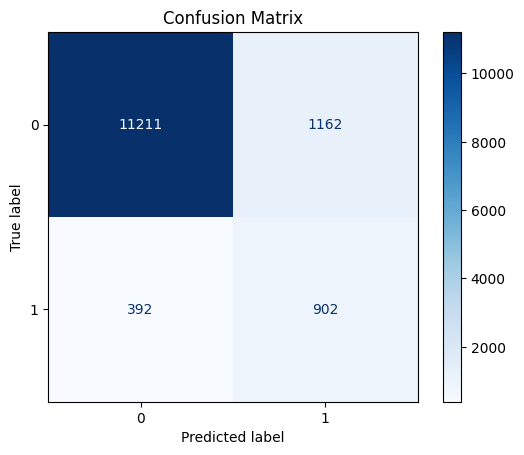


True Negatives: 11211
False Positives: 1162
False Negatives: 392
True Positives: 902
Balanced Accuracy: 0.8016
F1-Score: 0.5372


In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

# 1. Generate the confusion matrix
cm = confusion_matrix(true_np, preds_np)

# 2. Print raw matrix
print("Confusion Matrix:")
print(cm)

# 3. Visualize the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

# 4. Extract specific values
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate balanced accuracy
bal_acc = balanced_accuracy_score(true_np, preds_np)

print(f"Balanced Accuracy: {bal_acc:.4f}")

f1 = f1_score(true_np, preds_np)

print(f"F1-Score: {f1:.4f}")